In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import scipy as sp
from sklearn import preprocessing

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Initialization

In [2]:
# read from csv into a new dataframe
raw_weather = pd.read_csv('weather_raw2.csv',index_col=1)

# reindex by appropriate datetime
raw_weather.index = pd.to_datetime(raw_weather.index,format='%Y-%m-%d %H:00:00 +0000 UTC')
raw_weather.index.names = ['']

# remove unused columns
raw_weather.drop(raw_weather.columns[np.array([0,1,2,3,4,9,10,13,15,16,17,19,20,21,23,24,25,26])],axis=1,inplace=True)

# rename and reorder columns
column_names = ['temp','tmin','tmax','pressure','humidity','wind','rain','snow','clouds']
raw_weather.columns = column_names
raw_weather = raw_weather[['temp','tmin','tmax','pressure','humidity','wind','clouds','rain','snow']]

In [3]:
# drops duplicate rows
raw_weather.drop_duplicates(inplace=True)

In [4]:
# TEMPORARY bypass missing 2014-2015 data
# weather = raw_weather.truncate('2016-01-01 00:00:00','2019-02-10 00:00:00')

# weather = raw_weather.copy(deep=False)

In [5]:
# add an 'impute_ok' column; True if time gap is less than 6 hours
orig_len = len(raw_weather.index)
raw_weather.insert(0,'impute_ok',True)
raw_weather['impute_ok'].iloc[1:orig_len]=(raw_weather.index[1:orig_len]-raw_weather.index[0:orig_len-1] <= '06:00:00')

In [6]:
# reindexes to add missing rows, for a total length of 53545
correct_dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')
raw_weather = raw_weather.reindex(index=correct_dt)

# fills gaps in data with True if less than 6 hours, False if more
raw_weather['impute_ok'].fillna(method='bfill',inplace=True)

In [7]:
# fn.plot_all(raw_weather,'2013-01-02 00:00:00','2019-02-09 00:00:00')
raw_weather.isnull().sum()

impute_ok        0
temp          1129
tmin          1129
tmax          1129
pressure      1129
humidity      1129
wind          1129
clouds        1129
rain         49699
snow         53440
dtype: int64

In [8]:
gap_hours = len(raw_weather) - raw_weather['impute_ok'].sum()
gap_hours

187

# Error omission

In [9]:
# set violating values to NaN based on hardcoded low and high limit values for each column separately
sparse_weather = raw_weather.copy(deep=True)

low_tuners = [0,250,240,250,900,5,0,0,0,0]
high_tuners = [2,350,350,350,1100,100,25,100,100,10]
j=0

for i in raw_weather.columns:
    sparse_weather[i].where(sparse_weather[i] >= low_tuners[j],inplace=True)
    sparse_weather[i].where(sparse_weather[i] <= high_tuners[j],inplace=True)
    j=j+1

In [10]:
# assigns NaN precip values to zero, this is an unconfirmed assumption
sparse_weather['rain'].replace(np.NaN,0,inplace=True)
sparse_weather['snow'].replace(np.NaN,0,inplace=True)

impute_ok       0
temp         1136
tmin         1136
tmax         1136
pressure     1521
humidity     2161
wind         1133
clouds       1129
rain            0
snow            0
dtype: int64


,temp,tmin,tmax,pressure,humidity,wind,clouds,rain,snow
count,52409.000000,52409.000000,52409.000000,52024.000000,51384.000000,52412.000000,52416.000000,53545.000000,53545.000000
mean,284.054993,282.372296,285.640959,1019.296882,70.529951,2.629684,39.862771,0.087347,0.001562
std,10.286522,10.320556,10.456941,9.548772,18.597557,1.762607,39.018485,0.920185,0.052598
min,251.790000,247.150000,254.881000,980.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,275.981333,274.150000,277.150000,1013.000000,57.000000,1.000000,1.000000,0.000000,0.000000
50%,284.340000,282.590000,286.150000,1019.000000,72.000000,2.000000,25.000000,0.000000,0.000000
75%,292.700000,291.150000,294.260000,1025.000000,87.000000,3.000000,90.000000,0.000000,0.000000
max,308.600000,307.180000,313.150000,1056.000000,100.000000,15.000000,100.000000,76.960000,4.000000


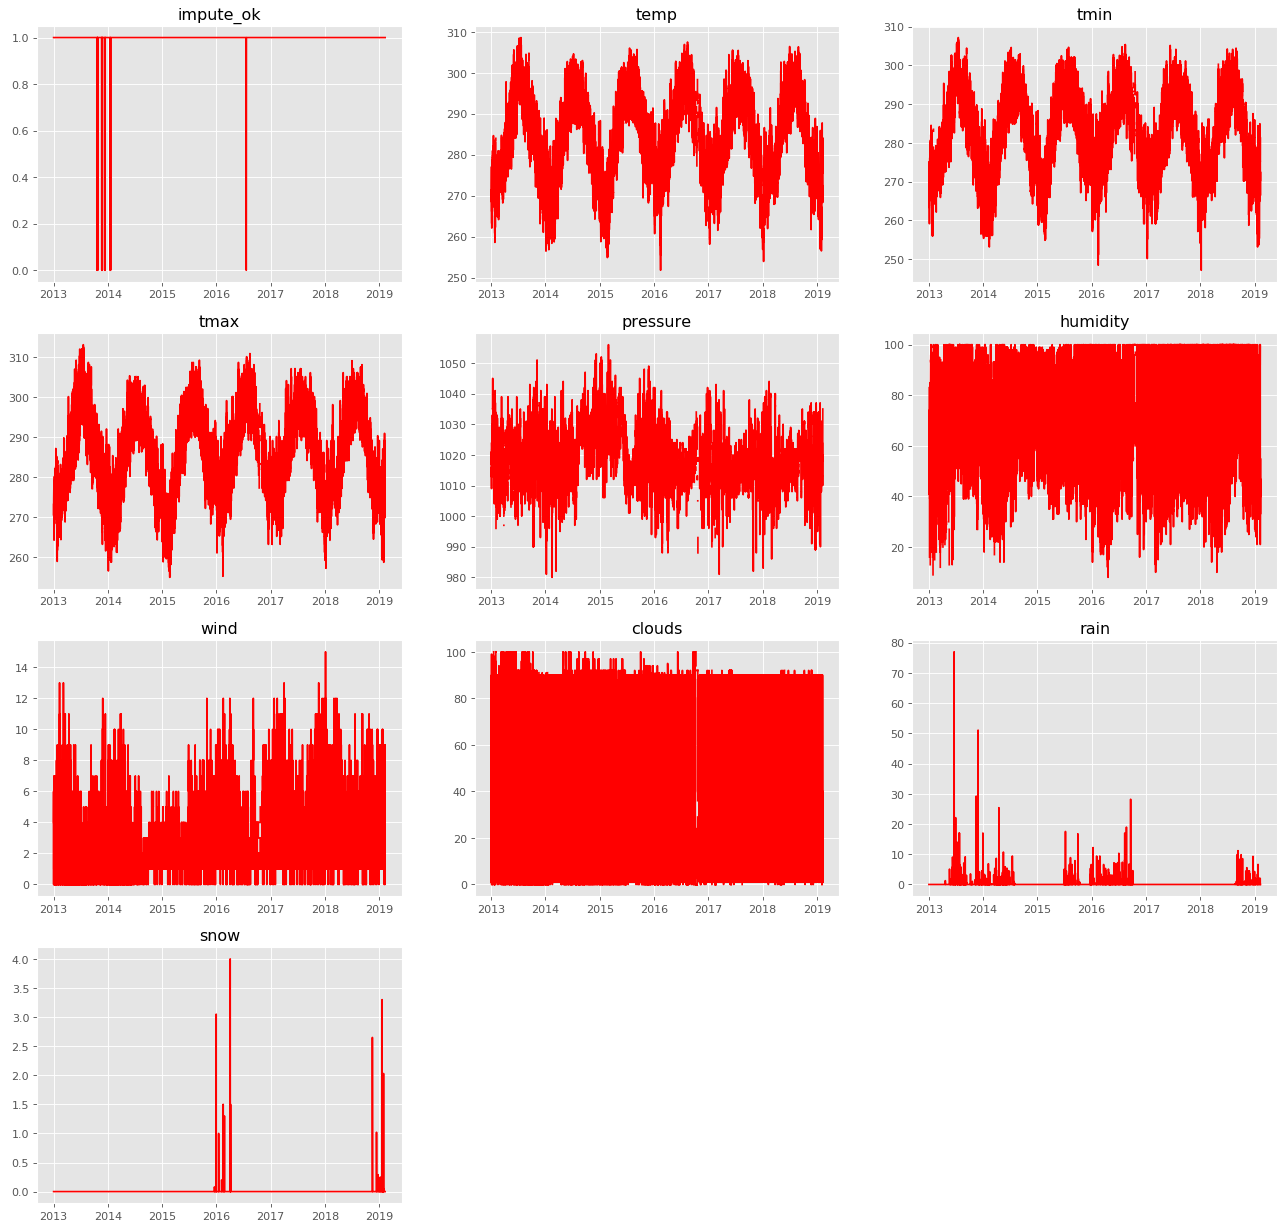

In [11]:
print(sparse_weather.isnull().sum())
fn.plot_all(sparse_weather,'2013-01-01 00:00:00','2019-02-10 00:00:00')
sparse_weather.describe()

In [15]:
fn.gap_indicator(sparse_weather,6).sum()

impute_ok    53545
temp         53391
tmin         53391
tmax         53391
pressure     53371
humidity     53114
wind         53381
clouds       53391
rain         53545
snow         53545
dtype: int64

In [16]:
counts = (sparse_weather.iloc[::-1]
                        .notna()
                        .rolling(6,min_periods=1)
                        .sum()
                        .iloc[::-1]
                        .astype(bool)
         )



counts_backward = (sparse_weather.notna()
                                 .rolling(6,min_periods=1)
                                 .sum()
                                 .astype(bool)
                  )

(counts & counts_backward).sum()

impute_ok    53545
temp         53391
tmin         53391
tmax         53391
pressure     53371
humidity     53114
wind         53381
clouds       53391
rain         53545
snow         53545
dtype: int64

In [14]:
weather.describe()

NameError: name 'weather' is not defined

In [ ]:
# imputes only values that have impute_ok = True
# in the future, try linear vs quadratic here
# weather.mask(weather['impute_ok']==True, weather.interpolate(method='polynomial', order=7, limit=6), inplace=True)

In [ ]:
# plot over missing chunk to check that the simple impute has yielded expected results
fn.plot_feature(weather,'temp','2016-07-15 00:00:00','2016-07-25 00:00:00')

In [ ]:
# fn.gap_check(weather)

In [ ]:
# imputes large segments, ignores period for now
# to be replaced by FFT imputation in the future
weather = weather.interpolate(method='linear')

# removes impute_ok column
weather.pop('impute_ok')

fn.plot_feature(weather,'temp','2016-07-17 00:00:00','2016-07-23 00:00:00')

In [ ]:
# this function adds columns with data from previous hours associated with the target hour
hours_before = np.arange(16,25)
weather_with_previous = fn.add_hours_before(weather,hours_before)
weather_with_previous.describe()

In [ ]:
# implements sklearn MinMaxScaler
x = weather_with_previous.values
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x)

scaled = pd.DataFrame(x_scaled)
scaled.columns = weather_with_previous.columns
scaled.index = weather_with_previous.index

scaled.describe()

In [ ]:
# scaled.to_csv('weather_clean.csv')

# unused code below

In [ ]:
# # returns index labels where nan values appear for a certain column
# nan_index = weather['temp'].index[weather['temp'].apply(np.isnan)]
# nan_index

# correct and complete datetime index for the date range considered
# dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')

# # renames (here, makes lowercase) column labels using a simple loop
# df.columns = [x.lower() for x in df.columns]

# # implements sklearn scaler
# from sklearn import preprocessing
# x = df.values #returns a numpy array
# scaler = preprocessing.MinMaxScaler()
# x_scaled = scaler.fit_transform(x)
# df = pandas.DataFrame(x_scaled)